In [1]:
import ajf_plts
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

SEED = ajf_plts.get_seed("3_generate_vehicle_loads.ipynb")


plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

# Load WIM data

In [2]:
wim_df = pd.read_feather("../data/wim_data.feather")
wim_df.head()

,Axles,S0,S1,S2,S3,S4,S5,SiteID,Timestamp,VehicleClass,W1,W2,W3,W4,W5,W6,dayofweek,hour,month
0,5,0.0,5.70,7.0,17.55,18.8,NaN,1015,2014-03-08 16:59:21.999958,5,50013.915,74530.540,110815.145,50013.915,47071.92,0.0,5,16,3
1,2,0.0,5.80,NaN,NaN,NaN,NaN,1015,2014-03-08 17:03:58.000000,4,50994.580,108853.815,0.000,0.000,0.00,0.0,5,17,3
2,2,0.0,6.55,NaN,NaN,NaN,NaN,1015,2014-03-08 17:12:53.000035,4,57859.235,98066.500,0.000,0.000,0.00,0.0,5,17,3
3,2,0.0,4.70,NaN,NaN,NaN,NaN,1015,2014-03-08 17:13:32.000045,4,40207.265,57859.235,0.000,0.000,0.00,0.0,5,17,3
4,2,0.0,6.10,NaN,NaN,NaN,NaN,1015,2014-03-08 17:15:04.999973,4,57859.235,84337.190,0.000,0.000,0.00,0.0,5,17,3


## Site IDs

!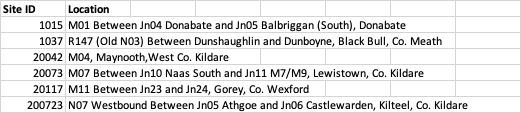

# Distribution of traffic volume across months

In [3]:
counts = wim_df.groupby(["SiteID", "month"]).agg("count").S0

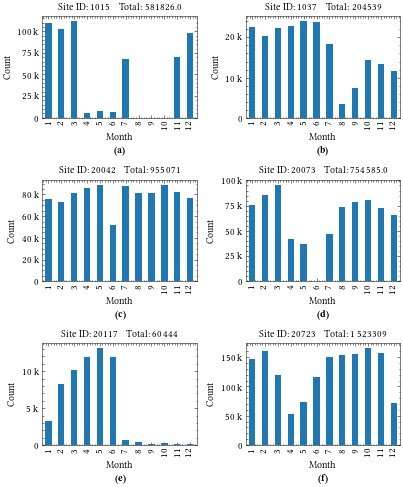

In [4]:
figsize = (ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2, nrows=3)
for ax, id in zip(axes.ravel(), wim_df.SiteID.unique()):
    counts = (
        wim_df[wim_df.SiteID == id]
        .groupby("month")
        .count()
        .S0.reindex(np.arange(1, 13))
    )
    counts.plot.bar(ax=ax)
    ax.set_title(rf"Site ID: {id}\quad Total: \num{{{counts.sum()}}}")
    ax.set_xlabel("Month")
    ax.set_ylabel(r"Count")
    ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter())
ajf_plts.caption_axes(axes.ravel())
fig.tight_layout()

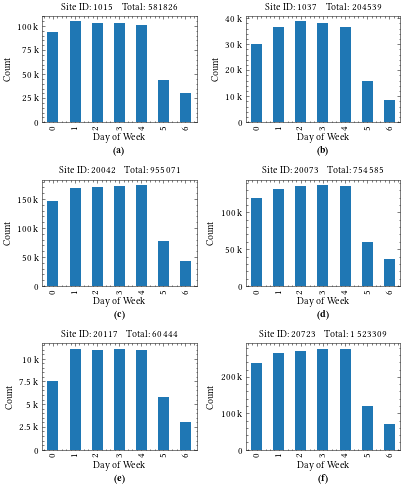

In [5]:
figsize = (ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2, nrows=3)
for ax, id in zip(axes.ravel(), wim_df.SiteID.unique()):
    counts = (
        wim_df[wim_df.SiteID == id]
        .groupby("dayofweek")
        .count()
        .S0.reindex(np.arange(0, 7))
    )
    counts.plot.bar(ax=ax)
    ax.set_title(rf"Site ID: {id}\quad Total: \num{{{counts.sum()}}}")
    ax.set_xlabel("Day of Week")
    ax.set_ylabel(r"Count")
    ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter())
ajf_plts.caption_axes(axes.ravel())
fig.tight_layout()

In [6]:
wim_df["year"] = wim_df.Timestamp.dt.year
wim_df["month"] = wim_df.Timestamp.dt.month
wim_df["day"] = wim_df.Timestamp.dt.day
wim_df["hour"] = wim_df.Timestamp.dt.hour
wim_df["minute"] = wim_df.Timestamp.dt.minute
wim_site_df = wim_df[wim_df.SiteID == 20042].copy()

Hourly 2-axles mean: 77.98
Minute 2-axles mean: 1.2996666666666667
Hourly 5-axles mean: 69.18
Minute 5-axles mean: 1.153
Hourly 6-axles mean: 31.78
Minute 6-axles mean: 0.5296666666666666


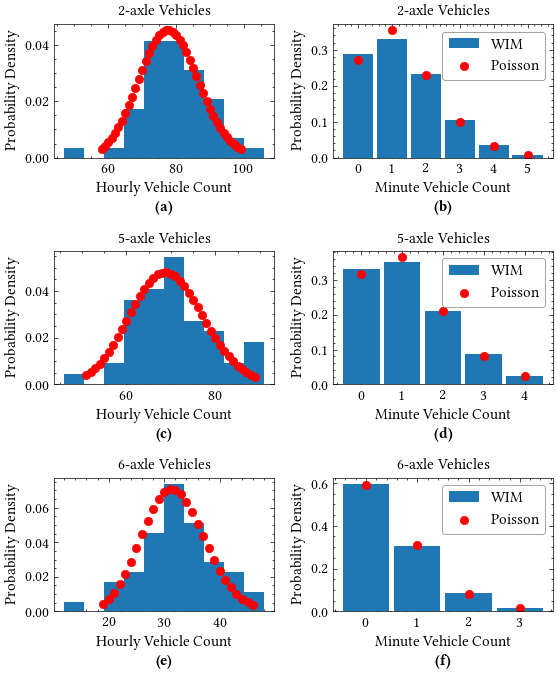

In [8]:
%matplotlib widget


def mi_reindex(df, idx, axis=0):
    if axis == 1:
        df = df.T
    if not isinstance(idx, pd.Index):
        raise ValueError("idx must be an index object")
    if (not all(idx.names)) or (not all(df.index.names)):
        raise ValueError("All indexes must have non-null names")
    if set(idx.names) - set(df.index.names):
        raise ValueError("idx names must be a subset of df index names")

    meta = df.index.to_frame(index=False)
    idx_df = idx.to_frame(index=False)
    new_meta = (
        meta.drop(idx_df.columns, axis=1)
        .drop_duplicates()
        .merge(idx_df, how="cross")[meta.columns]
    )
    df = df.reindex(pd.MultiIndex.from_frame(new_meta))
    if axis == 1:
        df = df.T
    return df


figsize = (
    ajf_plts.text_width_inches,
    3.0 * ajf_plts.fig_height_inches,
)
fig, axes = plt.subplots(figsize=figsize, nrows=3, ncols=2)

dow = 4
hour = 7

for i, axles in enumerate([2, 5, 6]):
    # HOURLY COUNT
    df = (
        wim_site_df.groupby(["Axles", "month", "day", "dayofweek", "hour"])
        .S0.agg("count")
        .loc[axles, :, :, dow, hour]
    )

    print(f"Hourly {axles}-axles mean: {df.mean()}")
    poisson_rv = stats.poisson(df.mean())
    x = np.arange(poisson_rv.ppf(0.01), poisson_rv.ppf(0.99) + 1)
    Px = poisson_rv.pmf(x)

    df[df.values > 10].plot(ax=axes[i, 0], kind="hist", density=True)
    axes[i, 0].scatter(x, poisson_rv.pmf(x), c="r")
    # axes[i,0].set_xlim((poisson_rv.ppf(0.01) - 5, poisson_rv.ppf(0.99) + 5))

    axes[i, 0].set_xlabel("Hourly Vehicle Count")
    axes[i, 0].set_ylabel("Probability Density")
    axes[i, 0].set_title(f"{axles}-axle Vehicles")

    # MINUTE COUNT
    df = (
        wim_site_df.groupby(["Axles", "month", "day", "dayofweek", "hour", "minute"])
        .S0.agg("count")
        .loc[axles, :, :, dow, hour, :]
    )
    df = mi_reindex(df, pd.Index(sorted(wim_df.minute.unique()), name="minute")).fillna(
        0
    )

    print(f"Minute {axles}-axles mean: {df.mean()}")
    poisson_rv = stats.poisson(df.mean())
    x = np.arange(poisson_rv.ppf(0.01), poisson_rv.ppf(0.99) + 1)
    Px = poisson_rv.pmf(x)

    df.plot(
        ax=axes[i, 1],
        kind="hist",
        bins=np.append(x, x.max() + 1) - 0.5,
        rwidth=0.9,
        density=True,
        label="WIM",
    )
    axes[i, 1].scatter(x, Px, c="r", label="Poisson")
    axes[i, 1].set_xticks(x)
    axes[i, 1].set_xlabel("Minute Vehicle Count")
    axes[i, 1].set_ylabel("Probability Density")
    axes[i, 1].set_title(f"{axles}-axle Vehicles")
    axes[i, 1].legend()

ajf_plts.caption_axes(axes.ravel())

fig.tight_layout()
ajf_plts.save_fig(fig, "figPoissonHourMinute.pdf")

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


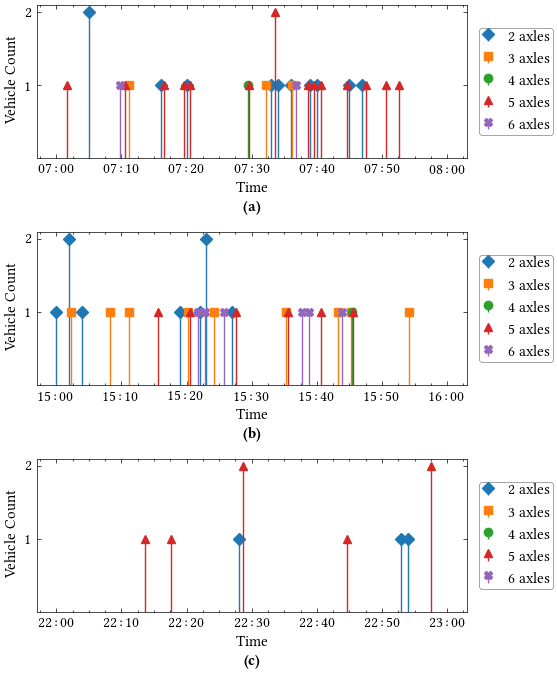

In [9]:
RNG = np.random.Generator(np.random.PCG64(SEED))

n_vehicles_annual = 100000
n_vehicles_weekly = n_vehicles_annual // 52

figsize = (
    ajf_plts.text_width_inches,
    3.0 * ajf_plts.fig_height_inches,
)
fig, axes = plt.subplots(figsize=figsize, nrows=3, ncols=1)

dow = 4

for i, hour in enumerate([7, 15, 22]):
    df = wim_site_df.sample(n_vehicles_weekly, random_state=RNG)
    rates = (
        df.groupby(["Axles", "dayofweek", "hour"])
        .S0.agg("count")
        .loc[:, dow, hour]
        .reindex(np.arange(2, 7))
        .fillna(0)
    )
    start = pd.to_datetime(f"{hour}:00:00")
    times = np.array(
        [start + pd.to_timedelta(mins, unit="m") for mins in np.arange(60)]
    )

    for j, (axles, marker) in enumerate(
        zip([2, 3, 4, 5, 6], ["D", "s", "o", "^", "X"])
    ):
        # HOURLY COUNT
        poisson_rv = stats.poisson(rates[axles] / 60)

        counts = poisson_rv.rvs(60, random_state=RNG).astype(float)
        counts[counts == 0] = np.nan

        x = times + pd.to_timedelta(j / 5.0, "m")

        axes[i].stem(
            x,
            counts,
            markerfmt=f"C{j}{marker}",
            linefmt=f"C{j}",
            basefmt=" ",
            label=f"{axles} axles",
        )

    axes[i].set_xlabel("Time")
    axes[i].set_xlim(
        (pd.to_datetime(f"{hour-1}:57:00"), pd.to_datetime(f"{hour+1}:03:00"))
    )

    axes[i].xaxis.set_major_locator(
        mpl.dates.MinuteLocator(byminute=np.arange(0, 70, 10))
    )
    axes[i].xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))

    axes[i].set_ylabel("Vehicle Count")
    ylim = axes[i].get_ylim()
    axes[i].set_yticks(np.arange(1, np.ceil(axes[i].get_ylim()[1])))
    axes[i].set_ylim((0, ylim[1]))
    axes[i].tick_params(axis="y", which="minor", left=False, right=False)
    axes[i].legend(
        loc="center left",
        bbox_to_anchor=(1.01, 0.5),
        borderpad=0.15,
        handlelength=1.0,
        columnspacing=0.5,
    )

ajf_plts.caption_axes(axes.ravel())

fig.tight_layout()
ajf_plts.save_fig(fig, "figExampleVehicleArrivals.pdf")

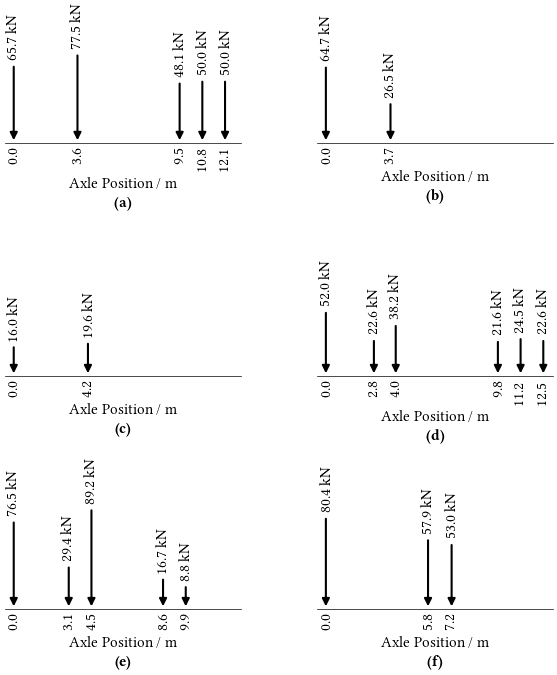

In [9]:
axle_counts = np.array([5, 2, 2, 6, 5, 3])

figsize = (
    ajf_plts.text_width_inches,
    3.0 * ajf_plts.fig_height_inches,
)
fig, axes = plt.subplots(figsize=figsize, nrows=3, ncols=2)
axes = axes.ravel()

weight_scale = 1.0
weight_offset = 20.0

for i, axles in enumerate(axle_counts):
    df = wim_df.loc[wim_df.Axles == axles].sample(random_state=RNG)

    pos_cols = [f"S{j}" for j in np.arange(axles)]
    weight_cols = [f"W{j+1}" for j in np.arange(axles)]

    ax_pos = df[pos_cols].values.flatten()
    weights = df[weight_cols].values.flatten() / 1e3

    axes[i].scatter(ax_pos, weights, c="none")

    for j in np.arange(axles):
        pos = ax_pos[j]
        weight = weights[j]
        axes[i].annotate(
            text=rf"{weight:2.1f}\,kN",
            xytext=(pos, weight_scale * weight + weight_offset),
            xy=(pos, 0),
            xycoords="data",
            arrowprops=dict(arrowstyle="-|>", facecolor="k", lw=1.5),
            rotation=90,
            ha="center",
            va="bottom",
        )

    axes[i].set_xticks(ax_pos)
    axes[i].set_xticklabels([rf"{x:2.1f}" for x in ax_pos])


for ax in axes:
    ax.set_xlabel("Axle Position / m")
    ax.set_xlim(-0.5, 13)
    ax.set_ylim(0, weight_scale * 100)

    ax.tick_params(axis="x", which="both", top=False, bottom=False)
    ax.tick_params(axis="y", which="both", left=False, right=False)

    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_yticks([])

    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")


ajf_plts.caption_axes(axes)
fig.tight_layout(w_pad=5)
ajf_plts.save_fig(fig, "figAxeWeightsSpacings.pdf")

# Generate 51 years of timestamps

In [11]:
temp_df = pd.read_parquet("./temp-freq-e_val.parquet")

temp_df.head(), temp_df.tail()

(   air_temperature      freq  year  month  day  dayofweek  hour  minute  \
 0              3.9  5.795619     0      0    1          6     0       0   
 1              4.7  5.791108     0      0    1          6     1       0   
 2              5.0  5.784058     0      0    1          6     2       0   
 3              4.8  5.784858     0      0    1          6     3       0   
 4              4.2  5.789826     0      0    1          6     4       0   
 
           E_val  seq_month  
 0  2.892293e+10          0  
 1  2.887878e+10          0  
 2  2.880976e+10          0  
 3  2.881759e+10          0  
 4  2.886622e+10          0  ,
         air_temperature      freq  year  month  day  dayofweek  hour  minute  \
 534715             12.7  5.597308    60     11   31          4    19       0   
 534716             12.9  5.593378    60     11   31          4    20       0   
 534717             12.7  5.593709    60     11   31          4    21       0   
 534718             12.2  5.598031   

# Randomly sample a rate for each hour and axle count

In [12]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

RNG = np.random.Generator(np.random.PCG64(SEED))

AXLES = sorted(wim_df.Axles.unique())


def get_hour_day_axle_rates(hour, dayofweek):
    N_weekly = 100000 // 52
    week_sample = wim_df.iloc[RNG.choice(len(wim_df), N_weekly, replace=True)]
    day_sample = week_sample[week_sample.dayofweek == dayofweek]
    rates = day_sample[(day_sample.hour == hour)].groupby("Axles").count().S0
    return rates.reindex(AXLES).fillna(0).to_numpy()


rates = temp_df[["dayofweek", "hour"]].parallel_apply(
    lambda row: get_hour_day_axle_rates(row.hour, row.dayofweek), axis=1
)

rates_df = temp_df.join(
    pd.DataFrame(rates.to_list(), columns=[f"Rate{a}" for a in AXLES])
)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Now for each 1 minute sample how many of each vehicle should occur in that period

In [13]:
rates_df["minute"] = [np.arange(60) for _ in range(rates_df.shape[0])]
rates_df = rates_df.explode("minute").reset_index(drop=True)

rates_df.loc[rates_df["minute"] != 0, ["air_temperature", "freq", "E_val"]] = np.nan
rates_df.loc[:, ["air_temperature", "freq", "E_val"]] = (
    rates_df.loc[:, ["air_temperature", "freq", "E_val"]].interpolate().bfill().ffill()
)

rates_df.loc[rates_df["minute"] != 30, [f"Rate{a}" for a in AXLES]] = np.nan
rates_df.loc[:, [f"Rate{a}" for a in AXLES]] = (
    rates_df.loc[:, [f"Rate{a}" for a in AXLES]].interpolate().bfill().ffill()
)
rates_df.loc[:, [f"Rate{a}" for a in AXLES]] /= 60.0

In [14]:
n_df = rates_df.loc[:, [f"Rate{a}" for a in AXLES]].parallel_applymap(
    lambda l: RNG.poisson(lam=l)
)
n_df.columns = AXLES
n_veh_df = pd.concat([rates_df, n_df], axis=1).drop(columns=[f"Rate{a}" for a in AXLES])

# Unpivot Number of vehicles
n_veh_df = n_veh_df.melt(
    id_vars=[
        "seq_month",
        "year",
        "month",
        "day",
        "hour",
        "minute",
        "dayofweek",
        "air_temperature",
        "freq",
        "E_val",
    ],
    value_vars=AXLES,
    var_name="AxleCount",
    value_name="NumVehicles",
)

# Repeat rows that have more than 1 vehicle of the same axle count
# Also removes rows with no vehicles
n_veh_df = n_veh_df.loc[n_veh_df.index.repeat(n_veh_df.NumVehicles)]

In [15]:
n_veh_df.sort_values(["seq_month", "day", "hour", "minute"]).head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,AxleCount,NumVehicles
64166496,0,0,0,1,1,36,6,4.880000,5.786878,2.883737e+10,4,1
32083483,0,0,0,1,4,43,6,3.555000,5.795990,2.892656e+10,3,1
32083510,0,0,0,1,5,10,6,3.216667,5.799653,2.896242e+10,3,1
32083512,0,0,0,1,5,12,6,3.200000,5.799898,2.896483e+10,3,1
417,0,0,0,1,6,57,6,3.655000,5.801216,2.897772e+10,2,1


In [16]:
n_veh_df.drop(columns=["NumVehicles"]).reset_index(drop=True).to_parquet(
    "vehicle_counts.parquet"
)

## Quick check to see how many multi vehicle events there are

In [18]:
print(f"Total Number of vehicles: {len(n_veh_df)}")
print("")

nv = 1

multi_mask = n_veh_df.NumVehicles == nv

while multi_mask.sum() > 0:
    print(f"N={nv}")
    print(f"Number of vehicles: {multi_mask.sum()}")
    print(f"Percentage vehicle: {100.0*multi_mask.sum()/len(n_veh_df):2.3f}%")
    print()
    nv += 1
    multi_mask = n_veh_df.NumVehicles == nv

Total Number of vehicles: 6116958

N=1
Number of vehicles: 5635726
Percentage vehicle: 92.133%

N=2
Number of vehicles: 455258
Percentage vehicle: 7.443%

N=3
Number of vehicles: 24852
Percentage vehicle: 0.406%

N=4
Number of vehicles: 1080
Percentage vehicle: 0.018%

N=5
Number of vehicles: 35
Percentage vehicle: 0.001%



In [19]:
n_veh_df.groupby("AxleCount").count()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,NumVehicles
AxleCount,,,,,,,,,,,
2,2000034,2000034,2000034,2000034,2000034,2000034,2000034,2000034,2000034,2000034,2000034
3,360247,360247,360247,360247,360247,360247,360247,360247,360247,360247,360247
4,919151,919151,919151,919151,919151,919151,919151,919151,919151,919151,919151
5,2073591,2073591,2073591,2073591,2073591,2073591,2073591,2073591,2073591,2073591,2073591
6,763935,763935,763935,763935,763935,763935,763935,763935,763935,763935,763935


/tmp/ipykernel_5114/2939266002.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(["", "Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"])


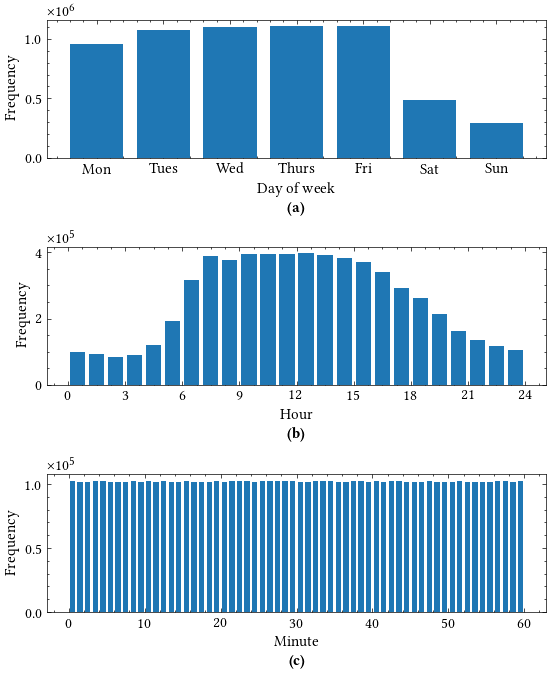

In [20]:
def plot_dists_day_hour_min(df):
    fig, axes = plt.subplots(
        figsize=(ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches), nrows=3
    )
    axes = axes.ravel()

    # Day of week
    df.dayofweek.plot(
        ax=axes[0], kind="hist", align="left", rwidth=0.8, bins=np.arange(8)
    )
    axes[0].set_xlabel("Day of week")
    axes[0].set_xticklabels(["", "Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"])

    # Hour of day
    df.hour.plot(ax=axes[1], kind="hist", rwidth=0.8, bins=np.arange(25))
    axes[1].set_xlabel("Hour")
    axes[1].set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

    # Minute
    df.minute.plot(
        ax=axes[2], kind="hist", stacked=True, rwidth=0.7, bins=np.arange(61)
    )
    axes[2].set_xlabel("Minute")

    ajf_plts.caption_axes(axes)
    fig.tight_layout()
    return fig


fig = plot_dists_day_hour_min(n_veh_df)

/tmp/ipykernel_5114/2939266002.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(["", "Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"])


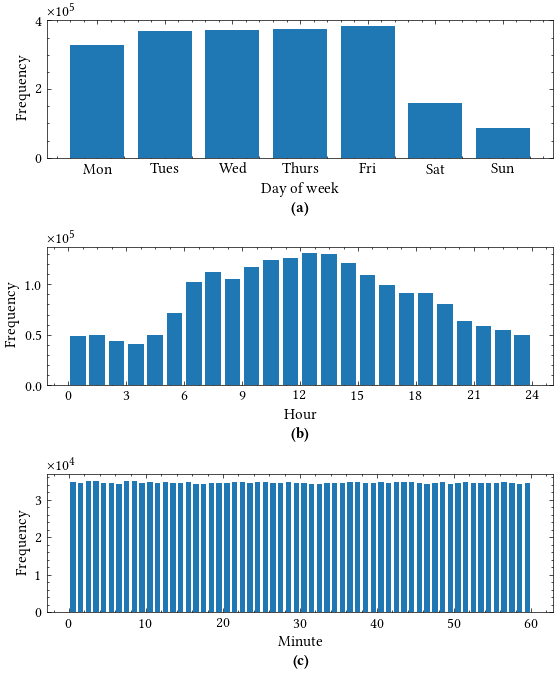

In [21]:
fig = plot_dists_day_hour_min(n_veh_df[n_veh_df.AxleCount == 5])

/tmp/ipykernel_5114/2939266002.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(["", "Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"])


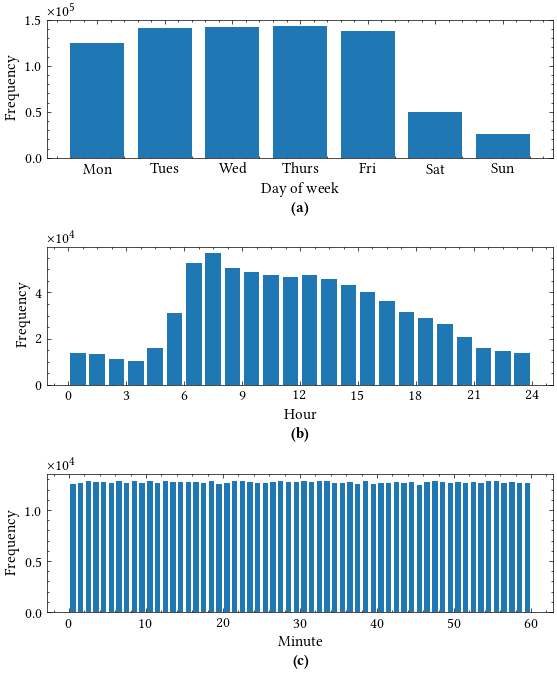

In [22]:
fig = plot_dists_day_hour_min(n_veh_df[n_veh_df.AxleCount == 6])